The dataset is made from high-rank League of Legends games, specifically:     

*   26,000 Challenger games  
*   65,000 Grandmaster games
*   100,000 Master games      
(estimated games)     
These are some of the highest competitive tiers, so the gameplay patterns are stable, strategic, and less random.   
The dataset includes key in-game factors that influence winning or losing.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Datasets
chal = pd.read_csv("Challenger_Ranked_Games.csv")
gm = pd.read_csv("GrandMaster_Ranked_Games.csv")
master = pd.read_csv("Master_Ranked_Games.csv")

# Define ranks
chal['rank'] = 'challenger'
gm['rank'] = 'grandmaster'
master['rank'] = 'master'

# Combine Datasets
df = pd.concat([master, gm, chal], ignore_index=True)

# Calculate Lead Scores (0-5)
df['blue_early_lead'] = (
    df['blueFirstBlood'] +
    df['blueFirstTower'] +
    df['blueFirstDragon'] +
    df['blueFirstBaron'] +
    df['blueFirstInhibitor']
)
df['red_early_lead'] = (
    df['redFirstBlood'] +
    df['redFirstTower'] +
    df['redFirstDragon'] +
    df['redFirstBaron'] +
    df['redFirstInhibitor']
)

# Throw Labels - Target
df['blue_throw'] = ((df['blue_early_lead'] >= 3) & (df['blueWins'] == 0)).astype(int)
df['red_throw'] = ((df['red_early_lead'] >= 3) & (df['redWins'] == 0)).astype(int)
df['either_throw'] = df['blue_throw'] | df['red_throw']
df = df.rename(columns={'gameDuraton': 'gameDuration'})

df.head()

,gameId,gameDuration,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt,rank,blue_early_lead,red_early_lead,blue_throw,red_throw,either_throw
0,4227123625,1429,0,1,1,0,0,0,0,0,...,127,4,12916,26338,master,2,1,0,0,0
1,4219545724,1313,0,0,1,0,0,0,0,0,...,133,4,12252,29828,master,1,2,0,0,0
2,4219463634,1660,1,0,0,1,1,1,1,1,...,153,2,17005,37066,master,3,2,0,0,0
3,4205778093,984,1,1,1,0,1,0,2,0,...,51,1,10499,3085,master,3,0,0,0,0
4,4201063474,1437,0,1,1,0,1,0,2,0,...,150,7,47523,47150,master,3,0,1,0,1


Axes(0.125,0.11;0.775x0.77)


either_throw,0,1
rank,,
challenger,0.895406,0.104594
grandmaster,0.896246,0.103754
master,0.897046,0.102954


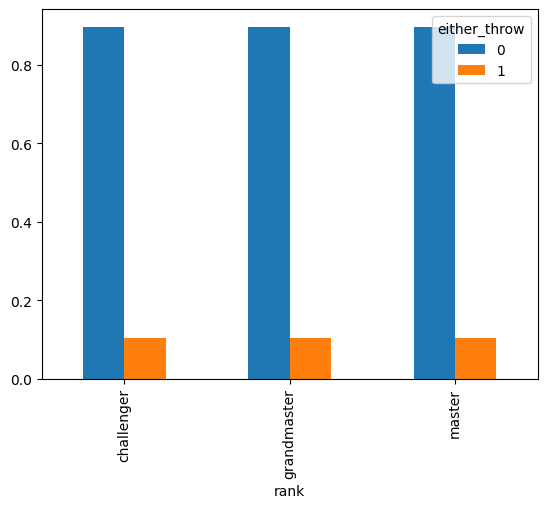

In [46]:
counts = df.groupby('rank')['either_throw'].value_counts(normalize = True).unstack()
print(counts.plot.bar())
counts

<Axes: xlabel='either_throw'>

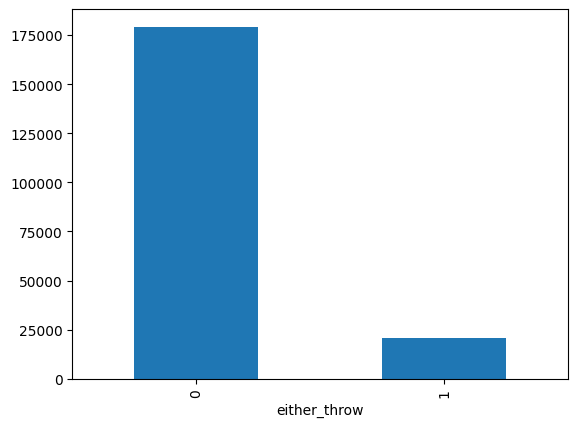

In [49]:
counts = df['either_throw'].value_counts()
counts.plot.bar()

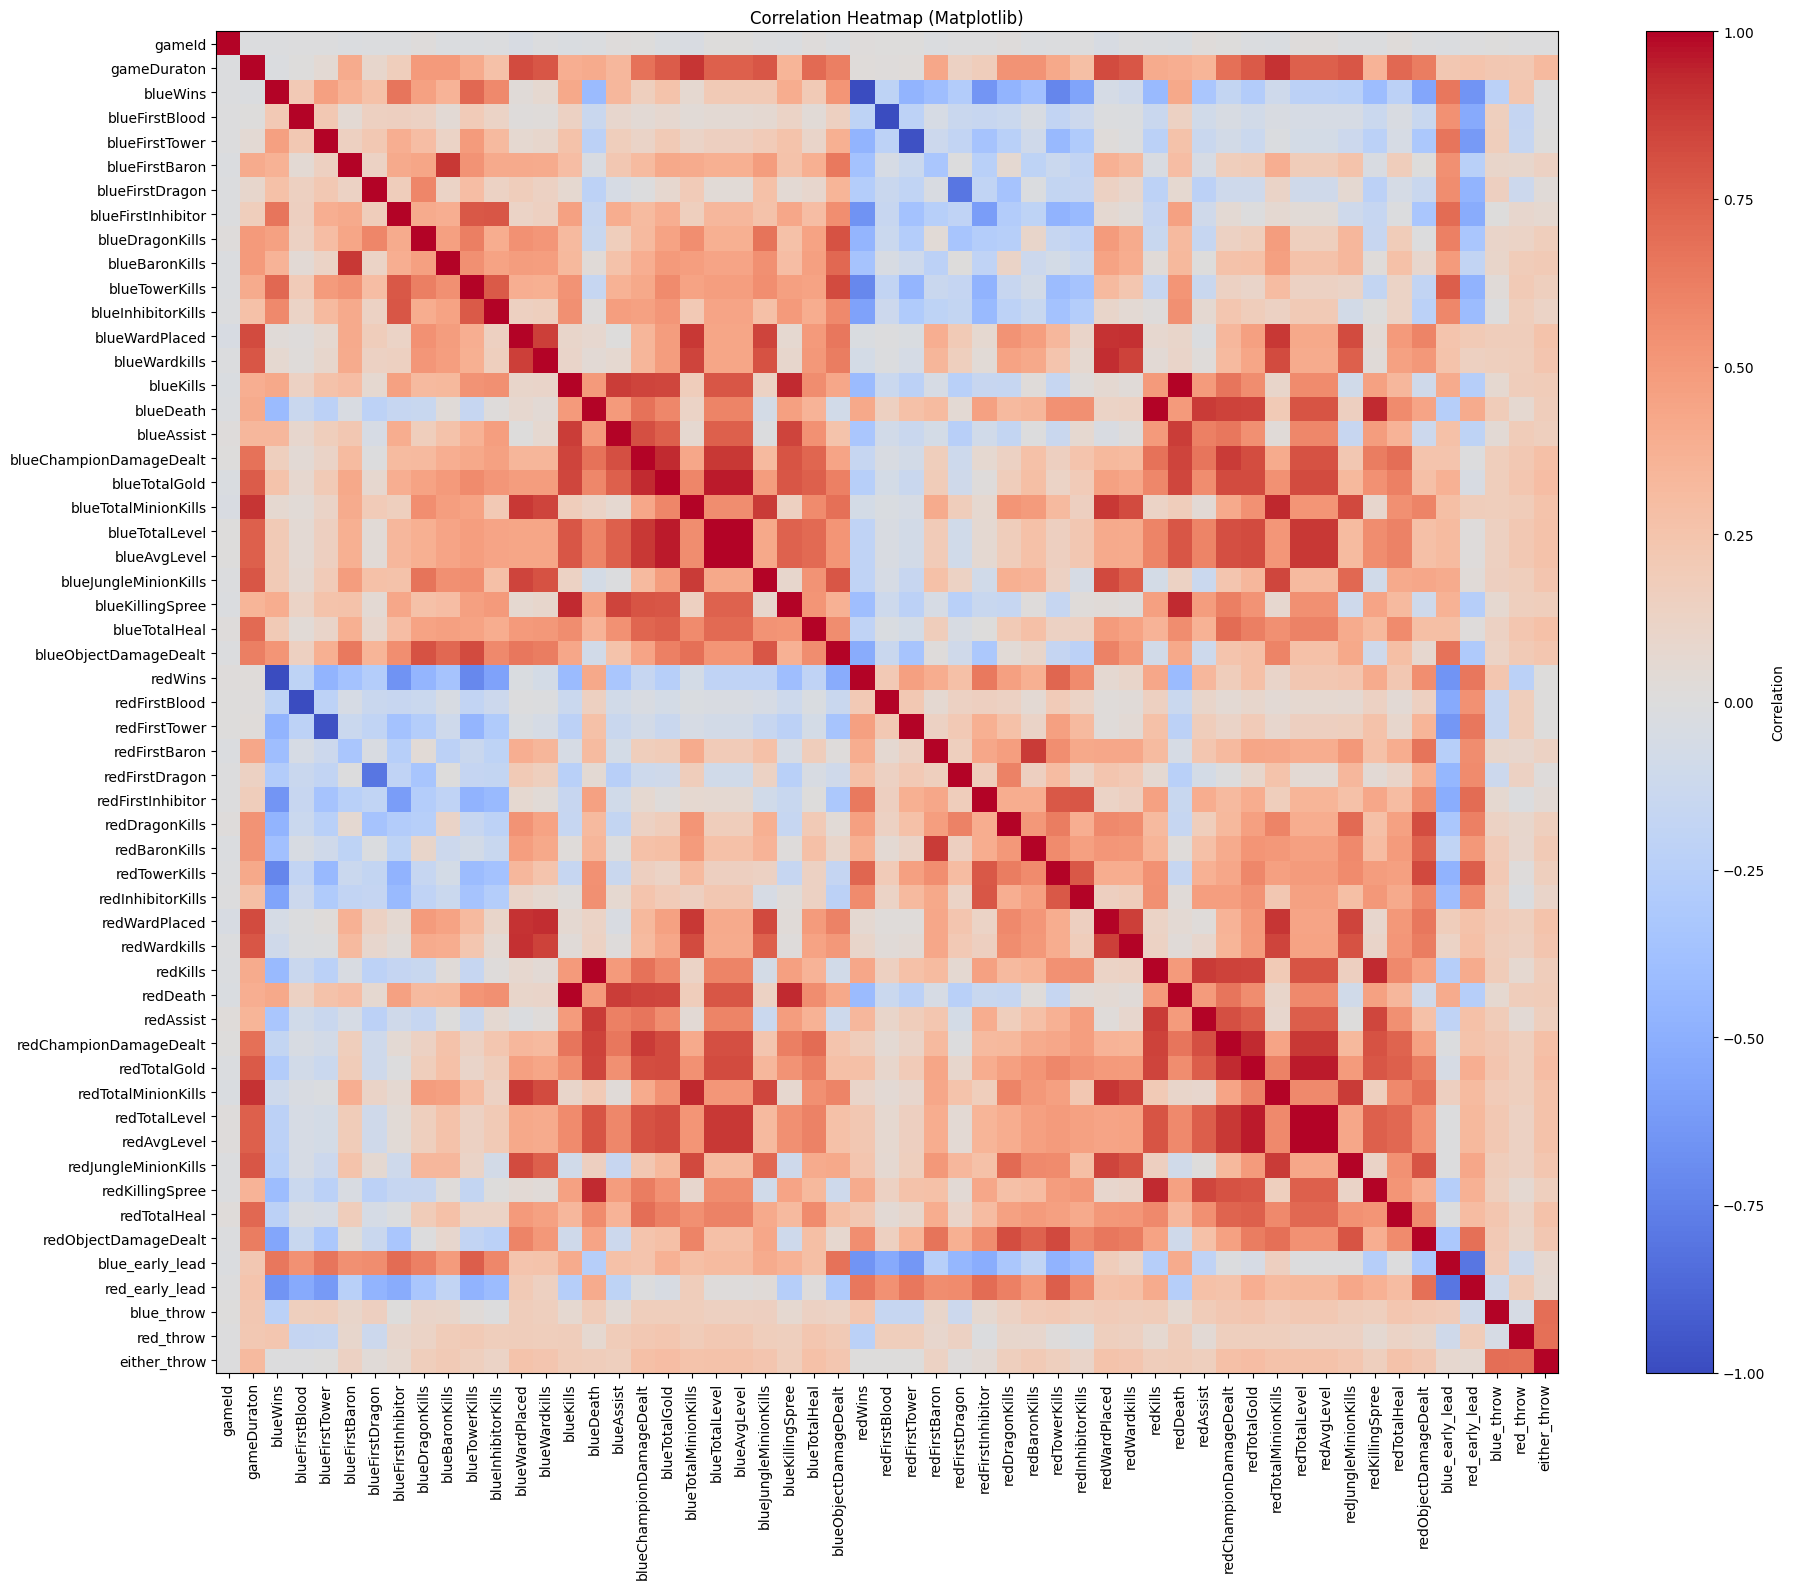

In [53]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Create heatmap
plt.figure(figsize=(20, 16))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Correlation")

# Add labels
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)

# Add title
plt.title("Correlation Heatmap (Matplotlib)")

plt.tight_layout()
plt.show()

In [74]:
def has(col):
    return col in df.columns

# Common diffs (adjust names if needed)
if has("blueTotalGold") and has("redTotalGold"):
    df["gold_diff"] = df["blueTotalGold"] - df["redTotalGold"]

if has("blueKills") and has("redKills"):
    df["kills_diff"] = df["blueKills"] - df["redKills"]

if has("blueTowerKills") and has("redTowerKills"):
    df["towers_diff"] = df["blueTowerKills"] - df["redTowerKills"]

if has("blueDragonKills") and has("redDragonKills"):
    df["dragons_diff"] = df["blueDragonKills"] - df["redDragonKills"]

if has("blueBaronKills") and has("redBaronKills"):
    df["barons_diff"] = df["blueBaronKills"] - df["redBaronKills"]


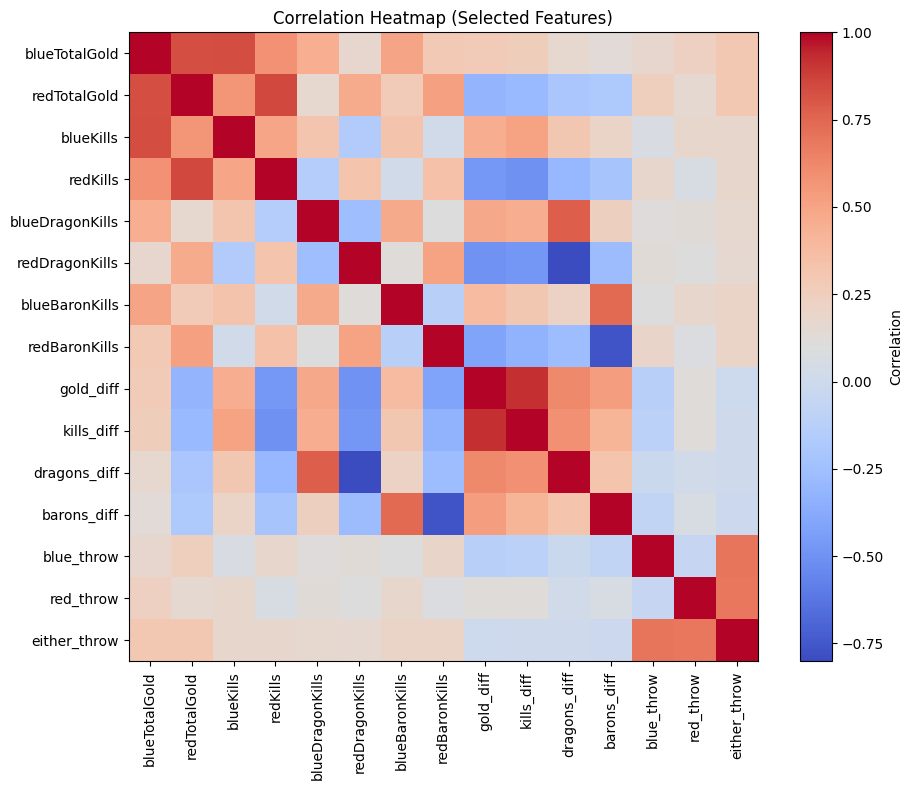

In [55]:
import numpy as np

candidate_cols = [
    "blueTotalGold", "redTotalGold",
    "blueKills", "redKills",
    "blueTowersDestroyed", "redTowersDestroyed",
    "blueDragonKills", "redDragonKills",
    "blueBaronKills", "redBaronKills",
    "gold_diff", "kills_diff", "towers_diff",
    "dragons_diff", "barons_diff",
    "blue_throw", "red_throw", "either_throw"
]

cols = [c for c in candidate_cols if c in df.columns]
corr = df[cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(np.arange(len(cols)), cols, rotation=90)
plt.yticks(np.arange(len(cols)), cols)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.show()


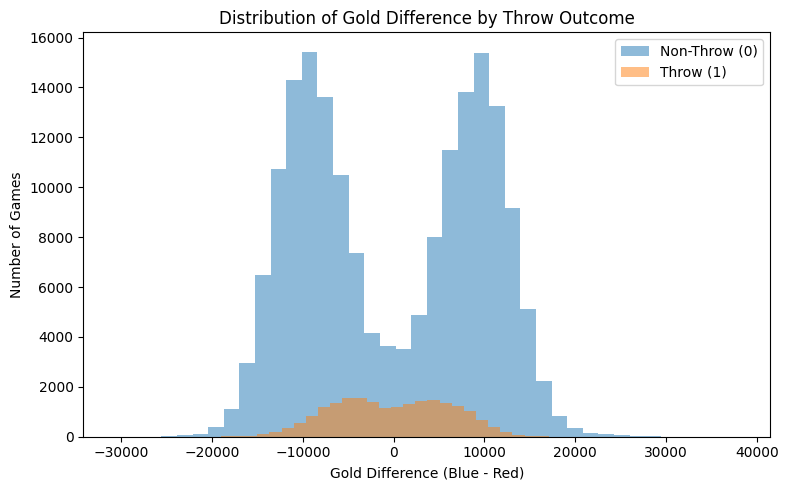

In [58]:
if "gold_diff" in df.columns:
    throw_mask = df["either_throw"] == 1
    non_throw_mask = df["either_throw"] == 0

    plt.figure(figsize=(8, 5))
    plt.hist(df[non_throw_mask]["gold_diff"], bins=40, alpha=0.5, label="Non-Throw (0)")
    plt.hist(df[throw_mask]["gold_diff"], bins=40, alpha=0.5, label="Throw (1)")

    plt.xlabel("Gold Difference (Blue - Red)")
    plt.ylabel("Number of Games")
    plt.title("Distribution of Gold Difference by Throw Outcome")
    plt.legend()
    plt.tight_layout()
    plt.show()

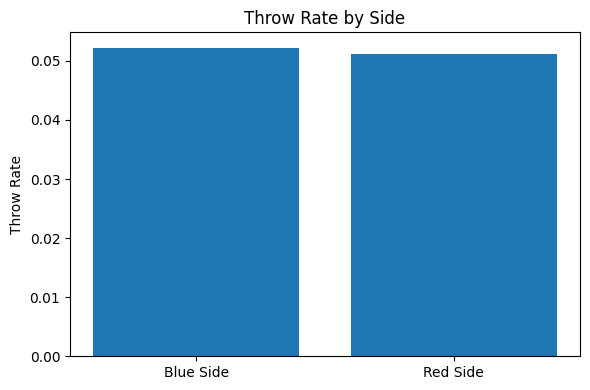

In [60]:
side_names = []
side_rates = []

if "blue_throw" in df.columns:
    side_names.append("Blue Side")
    side_rates.append(df["blue_throw"].mean())

if "red_throw" in df.columns:
    side_names.append("Red Side")
    side_rates.append(df["red_throw"].mean())

if side_names:
    x = np.arange(len(side_names))

    plt.figure(figsize=(6, 4))
    plt.bar(x, side_rates)
    plt.xticks(x, side_names)
    plt.ylabel("Throw Rate")
    plt.title("Throw Rate by Side")
    plt.tight_layout()
    plt.show()

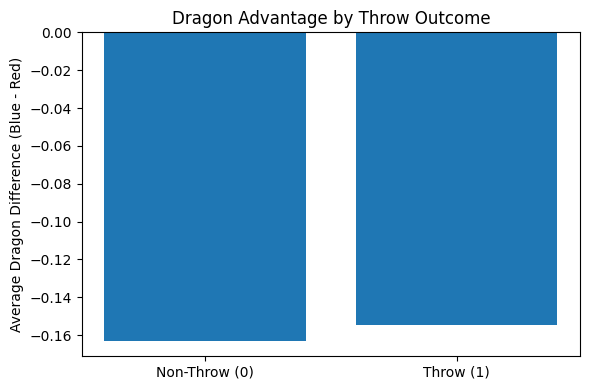

In [61]:
if "dragons_diff" in df.columns:
    avg_by_throw = df.groupby("either_throw")["dragons_diff"].mean()

    labels = ["Non-Throw (0)", "Throw (1)"]
    x = np.arange(2)

    plt.figure(figsize=(6, 4))
    plt.bar(x, avg_by_throw.values)
    plt.xticks(x, labels)
    plt.ylabel("Average Dragon Difference (Blue - Red)")
    plt.title("Dragon Advantage by Throw Outcome")
    plt.tight_layout()
    plt.show()


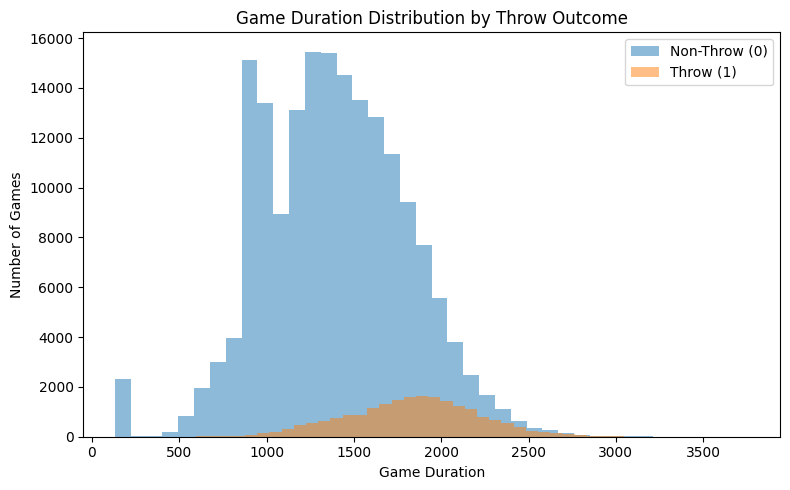

In [72]:
if "gameDuration" in df.columns:
    throw_mask = df["either_throw"] == 1
    non_throw_mask = df["either_throw"] == 0

    plt.figure(figsize=(8, 5))
    plt.hist(df[non_throw_mask]["gameDuration"], bins=40, alpha=0.5, label="Non-Throw (0)")
    plt.hist(df[throw_mask]["gameDuration"], bins=40, alpha=0.5, label="Throw (1)")
    plt.xlabel("Game Duration")
    plt.ylabel("Number of Games")
    plt.title("Game Duration Distribution by Throw Outcome")
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-1726135041.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throw_prob = df.groupby("duration_bin")["either_throw"].mean()


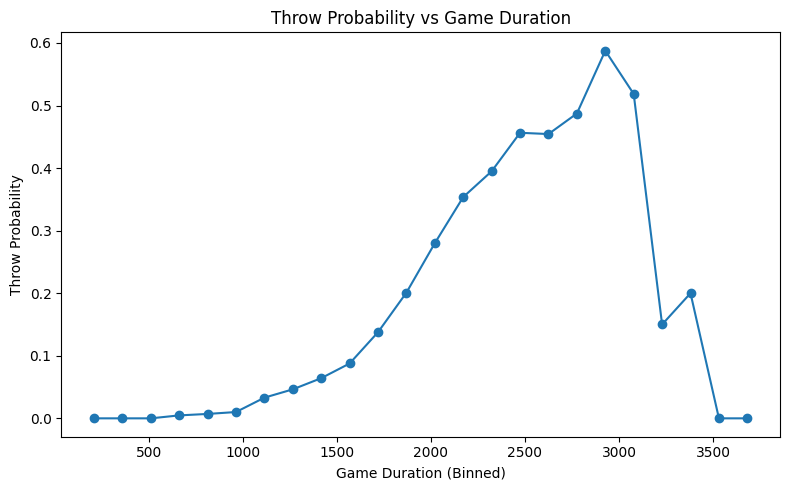

In [78]:
bins = np.linspace(df["gameDuration"].min(), df["gameDuration"].max(), 25)
df["duration_bin"] = pd.cut(df["gameDuration"], bins=bins)

throw_prob = df.groupby("duration_bin")["either_throw"].mean()
bin_centers = [b.mid for b in throw_prob.index.categories]

plt.figure(figsize=(8,5))
plt.plot(bin_centers, throw_prob.values, marker="o")

plt.xlabel("Game Duration (Binned)")
plt.ylabel("Throw Probability")
plt.title("Throw Probability vs Game Duration")
plt.tight_layout()
plt.show()

Data Quality.   
No missing values.   
Mostly numeric fields.   
Consistent structure across teams.   
No obvious outliers requiring removal.   

Consistency in throws across ranks (surprised i thought higher rank less throw)